# Parallellism and Large Language Model(LLM)

1. DP and DDP - Data parallel and distributed data parallel

  PyTorch provides several options for data-parallel training. For applications that gradually grow from simple to complex and from prototype to production, the common development trajectory would be:

  - Use single-device training if the data and model can fit in one GPU, and training speed is not a concern.

  - Use single-machine multi-GPU DataParallel to make use of multiple GPUs on a single machine to speed up training with minimal code changes.

  - Use single-machine multi-GPU DistributedDataParallel, if you would like to further speed up training and are willing to write a little more code to set it up.

  - Use multi-machine DistributedDataParallel and the launching script, if the application needs to scale across machine boundaries.

  - Use torch.distributed.elastic to launch distributed training if errors (e.g., out-of-memory) are expected or if resources can join and leave dynamically during training.

2. MP - Model parallel

  Let's looks at the released LLM - Bloom, whose architecture is very similar to GPT3 with a few added improvements.

  The 176B BLOOM model has been trained using Megatron-DeepSpeed, which is a combination of 2 main technologies:

  - DeepSpeed is a deep learning optimization library that makes distributed training easy, efficient, and effective.
  - Megatron-LM is a large, powerful transformer model framework developed by the Applied Deep Learning Research team at NVIDIA.


  | Component | DeepSpeed | Megatron-LM |
  | :-----| ----: | :----: |
  | ZeRO Data Parallelism | ☑️ |  |
  | Tensor Parallelism |  | ☑️  |
  |Pipeline Parallelism | ☑️  | |
  | BF16Optimizer | ☑️  | | 
  | Fused CUDA Kernels | | ☑️ |
  | DataLoader | | ☑️ |

## DP, DDP and ZeRo Data Parallelism

### DP

`torch.nn.DataParallel` will automatically slice and load the data to the different GPUs, it will also copy the model parameters to each GPU, perform forward propagation to calculate the gradient and aggregate it. To use the `torch.nn.DataParallel`, we only need to wrap the model with:

`model = nn.DataParallel(model,device_ids=gpu_ids)`

However, in the process of using it, you will find that the speedup is not obvious and there is a **serious load imbalance**. The main reason for this is that although the model processes the data in parallel with multiple GPUs, the first GPU will gather all the information to update the model parameters, so the load on the first GPU is much greater than the others. 

Disadvantage of DP: 

- The gradient calculation is aggregated in the first GPU, which causes the load on the first GPU to be much greater than the other GPUS. 
- DataParallel is single-process, multi-thread, and only works on a single machine

### DDP

Unlike DP, which is a single-process, multi-threaded approach, DDP is implemented through multiple processes way. DDP creates a process in each GPU device, it is a multi-process approach where the gradients are computed independently by each process and then aggregated and averaged, and then propagated to all processes. DDP is faster and avoids the problem of unbalanced load on multiple devices.

To use the ddp, you can check the official released tutorial in [PyTorch Documentation](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html). It requires you to do more coding works than the DP.

Advantage of DDP: 
- DistributedDataParallel is multi-process and works for both single- and multi- machine training.
- DistributedDataParallel works with model parallel; 

Disadvantage of DDP:

The model states - **model parameters, gradients, optmizer states** - is fully replicated to each GPU and then after each iteration all the models synchronize their states with each other. It only works if the model can fit onto a single GPU. It does not help reduce memory footprint per device: a model with more than 1 billion parameters runs out of memory even on GPUs with 32GB of memory.

### ZeRO DP
Instead of replicating the model states - model parameters, gradients, and the optimizer states - to each GPU, deepspeed's ZeRO(zero redundancy optmizer)uses a dynamic communication schedule during training to share the necessary state across devices. Each GPU stores only a slice of the model states, then at run-time when the full layer params are needed just for the given layer, all GPUs synchronize to give each other parts that they miss.


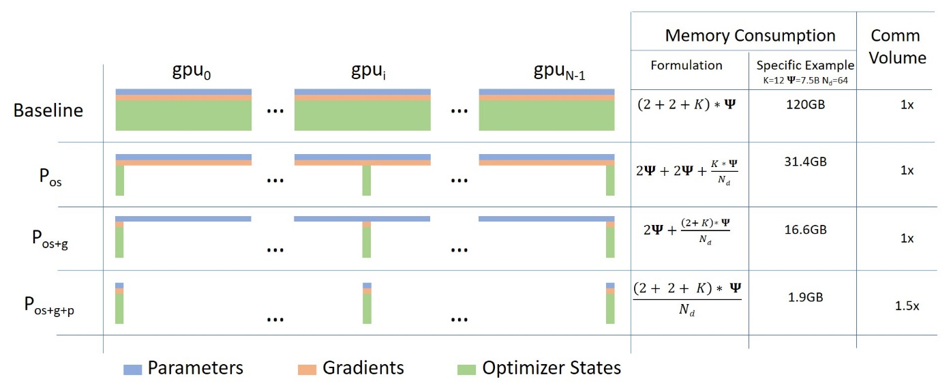

ZeRO DP sounds like an efficient strategy:

1. Harry Porter is good at Quidditch
2. Ron Weasley is good at Wizard chess
3. Hermione Jean Granger is good at Charm

For a examnation that consists of Quidditch, Wizard Chess and Charm, When Harry works on the Quidditich part, he will also clone himself twice to help Ron and Hermione. After he finish the Quidditch part, he will destroy his clones and ask Ron and Hermione to create clones to finish rest part. Each clone will be destroyed after finish the corresponding parts.

**DP and DDP**: Each of them has to finish the whole exam paper, Which would be far more inefficient. This is DataParallel (DP and DDP) in Pytorch.

**Naive MP**: Three exam papers will be finish one by one, Harry will first works on the Quidditch, and then pass the paper to Ron, after Ron finish it, Hermione will get the paper to finish the Charm part.

Consider this simple model with 3 layers, where each layer has 3 params:


```
La | Lb | Lc
---|----|---
a0 | b0 | c0
a1 | b1 | c1
a2 | b2 | c2
```

if we have three GPUs, the ZeRO will split the model states onto those GPUs.



```
GPU0:
La | Lb | Lc
---|----|---
a0 | b0 | c0

GPU1:
La | Lb | Lc
---|----|---
a1 | b1 | c1

GPU2:
La | Lb | Lc
---|----|---
a2 | b2 | c2
```

Now each of these GPUs will get the usual mini-batch as it works in DP and DDP:

First, the inputs hit the layer La.

Let’s focus just on GPU0: x0 needs a0, a1, a2 params to do its forward path, but GPU0 has only a0 - it gets sent a1 from GPU1 and a2 from GPU2, bringing all pieces of the model together.

In parallel, GPU1 gets mini-batch x1 and it only has a1, but needs a0 and a2 params, so it gets those from GPU0 and GPU2.

Same happens to GPU2.

As soon as the calculation is done, the data that is no longer needed gets dropped - it’s only used during the calculation.

And the whole process is repeated for layer Lb, then Lc forward-wise, and then backward Lc -> Lb -> La.

### Usage of Deepspeed

See more details in [huggingface integration page](https://huggingface.co/docs/transformers/main_classes/deepspeed)

### Model Parallelism

Naive Model Parallel (MP) is where one spreads groups of model layers across multiple GPUs. The mechanism is relatively simple - switch the desired layers .to() the desired devices.

For example, if the following diagram shows an 4-layer model:


```
=========  ==========
| 0 | 1 |  |  2 | 3 | 
=========  ==========
  gpu0       gpu1,
```

Naive MP just place layers 0-1 onto GPU0 and 2-3 to GPU1.
Now while data travels from layer 0 to 1, this is just the normal model. But when data needs to pass from layer 1 to layer 2 it needs to travel from GPU0 to GPU1 which introduces a communication overhead.

Then layers 2 to 3 are as a normal model would have and when the layer 3 completes we often need to send the data back to layer 0 where the labels are (or alternatively send the labels to the last layer). Now the loss can be computed and the optimizer can do its work.

Disadvantages: 
 - the main deficiency and why this one is called “naive” MP, is that all but one GPU is idle at any given moment. So if 4 GPUs are used, it’s almost identical to quadrupling the amount of memory of a single GPU, and ignoring the rest of the hardware.



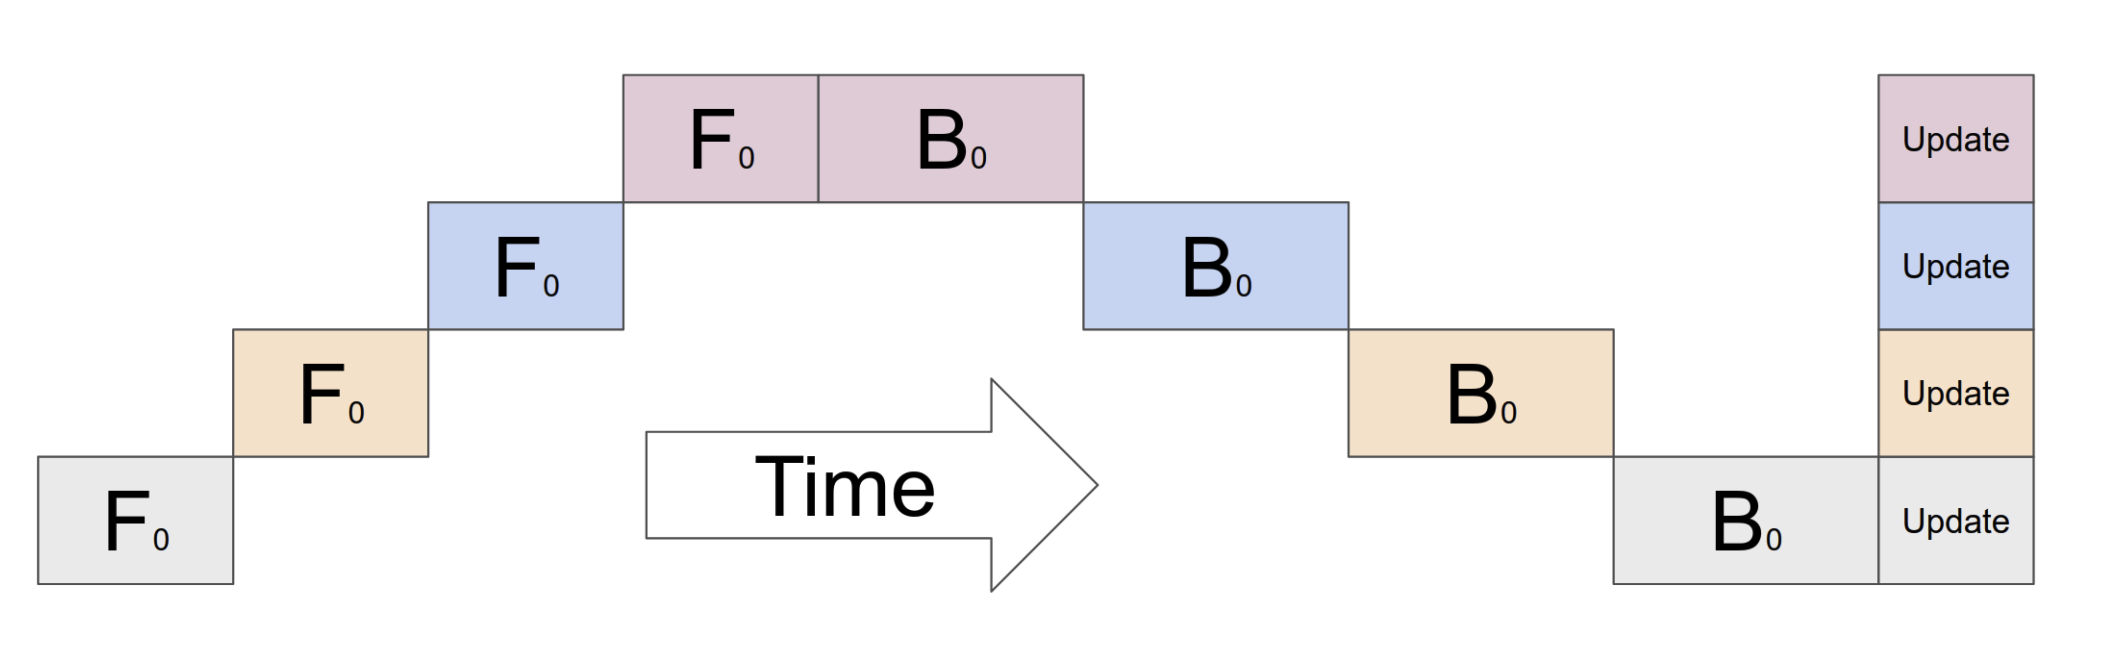

## Pipeline Parallelism

[GPipe](https://arxiv.org/pdf/1811.06965.pdf) proposed the pipeline parallelism(PP). PP introduces a new hyper-parameter to tune and it’s chunks which defines how many chunks of data are sent in a sequence through the same pipe stage. 

For example, in the bottomw diagram you can see that chunks=4. 

- GPU0 performs the same forward path on chunk 0, 1, 2 and 3 (F0,0, F0,1, F0,2, F0,3) 
- then it waits for other GPUs to do their work and 

- only when their work is starting to be complete, GPU0 starts to work again doing the backward path for chunks 3, 2, 1 and 0 (B0,3, B0,2, B0,1, B0,0).

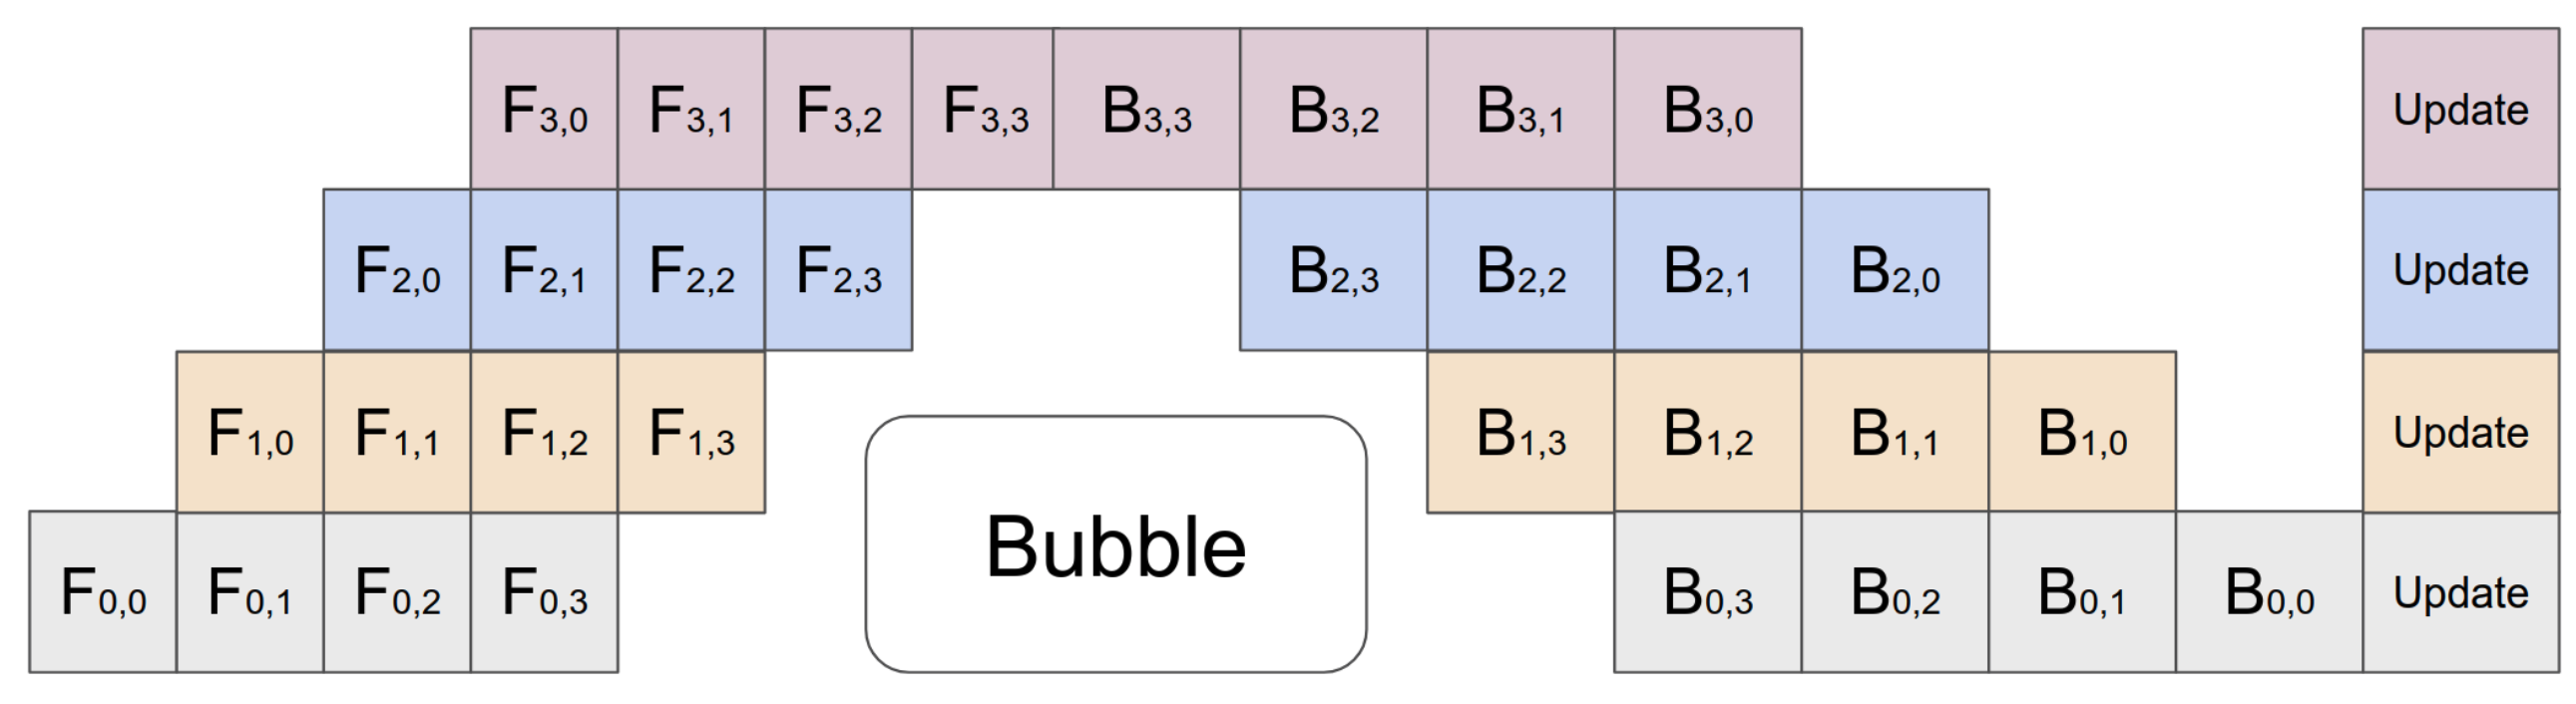

With chunks=1 you end up with the naive MP, which is very inefficient. With a very large chunks value you end up with tiny micro-batch sizes which could be not every efficient either. So one has to experiment to find the value that leads to the highest efficient utilization of the gpus.

## Deepspeed Interleaved Pipeline

In an interleaved pipeline, backward execution of the microbatches is prioritized whenever possible. This allows quicker release of the memory used for activations, using memory more efficiently. It also allows for scaling the number of microbatches higher, reducing the idle time of the GPUs. At steady-state, each device alternates between running forward and backward passes. This means that the backward pass of one microbatch may run before the forward pass of another microbatch finishes.

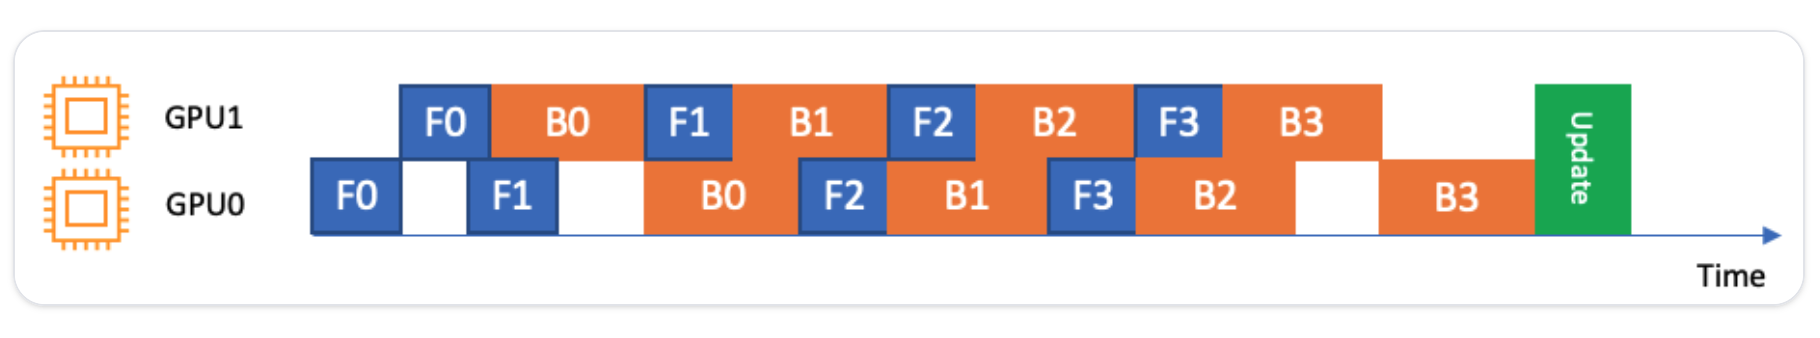

## Tensor Parallelism(TP) and Megatron - LM

Important observation: The main building block of any transformer is a fully connected `nn.Linear` followed by a nonlinear activation `GeLU` or `ReLU`.

We can write the dot-product part of it as Y = GeLU(XA), where X and Y are the input and output vectors(activations), and A is the weight matrix(model parameters).


it’s easy to see how the matrix multiplication can be split between multiple GPUs:

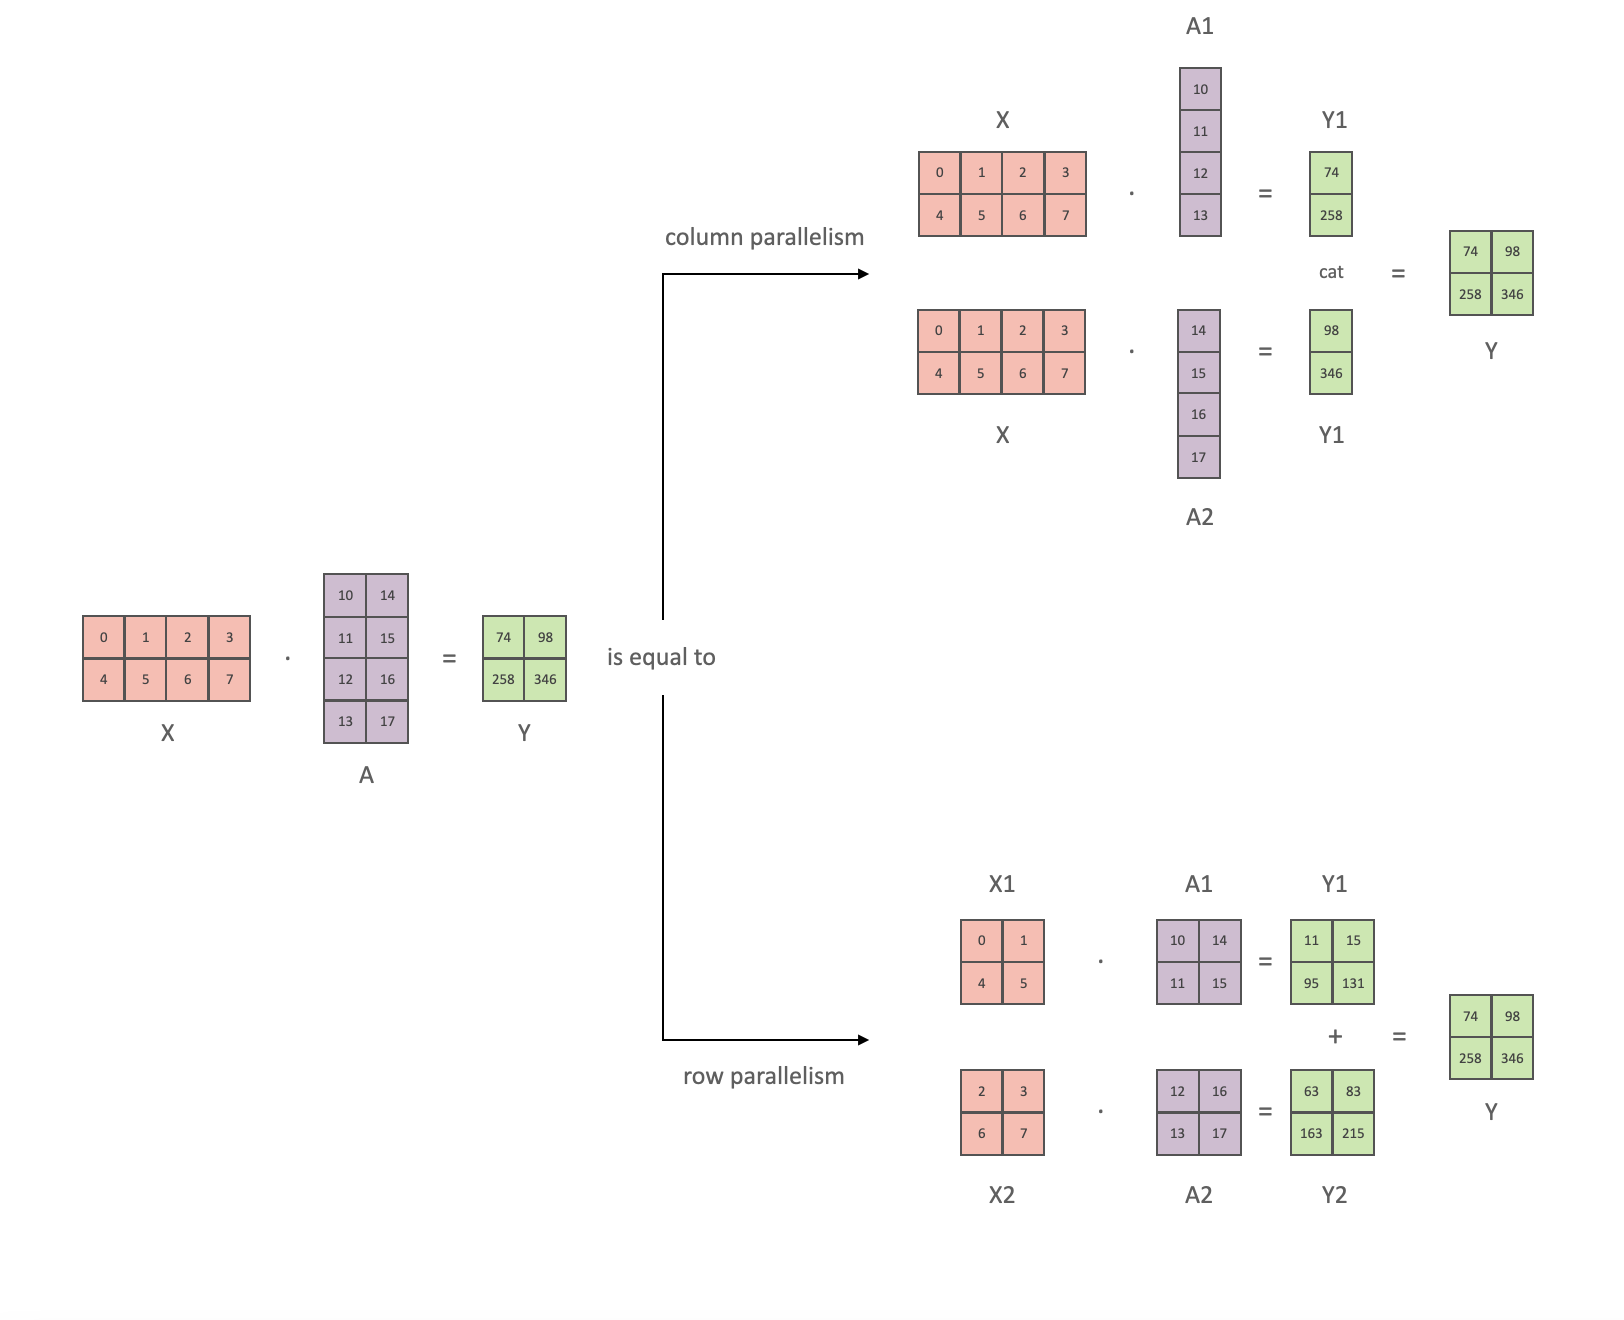

[Megatron-LM](https://arxiv.org/pdf/2104.04473.pdf): 

We can update an MLP of arbitrary depth, without the need for any synchronization between GPUs until the very end, where we need to reconstruct the output vector from shards. The Megatron-LM paper authors provide a helpful illustration for that:



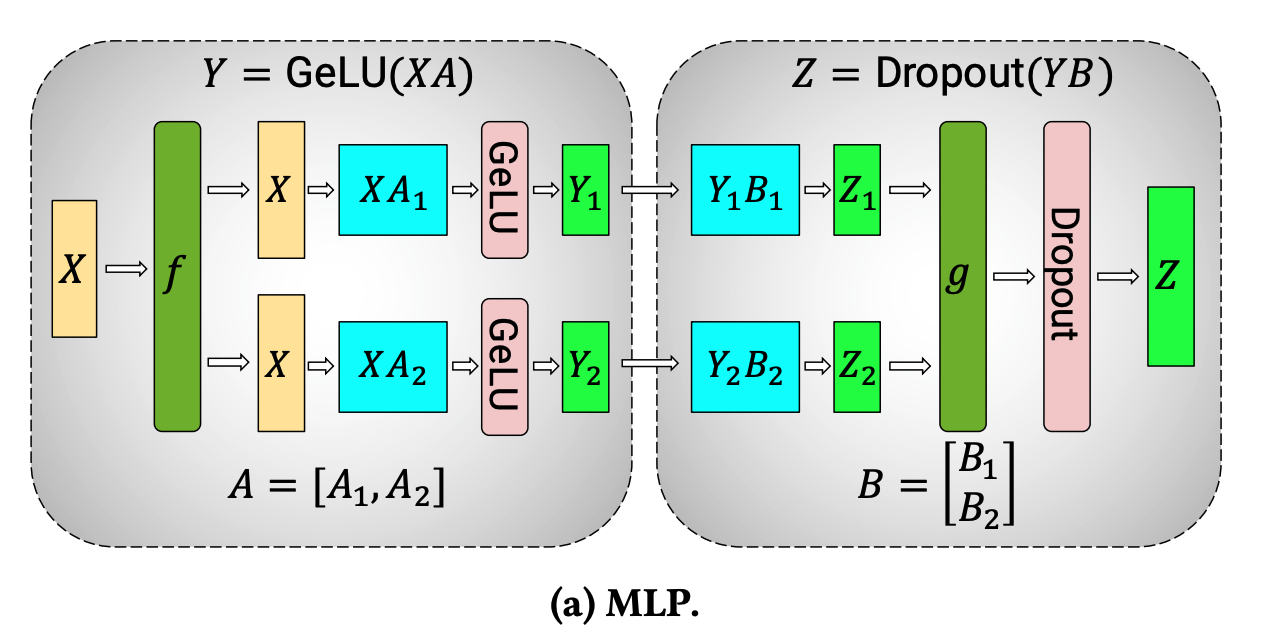

It is almost the same in the multi-head attention module:

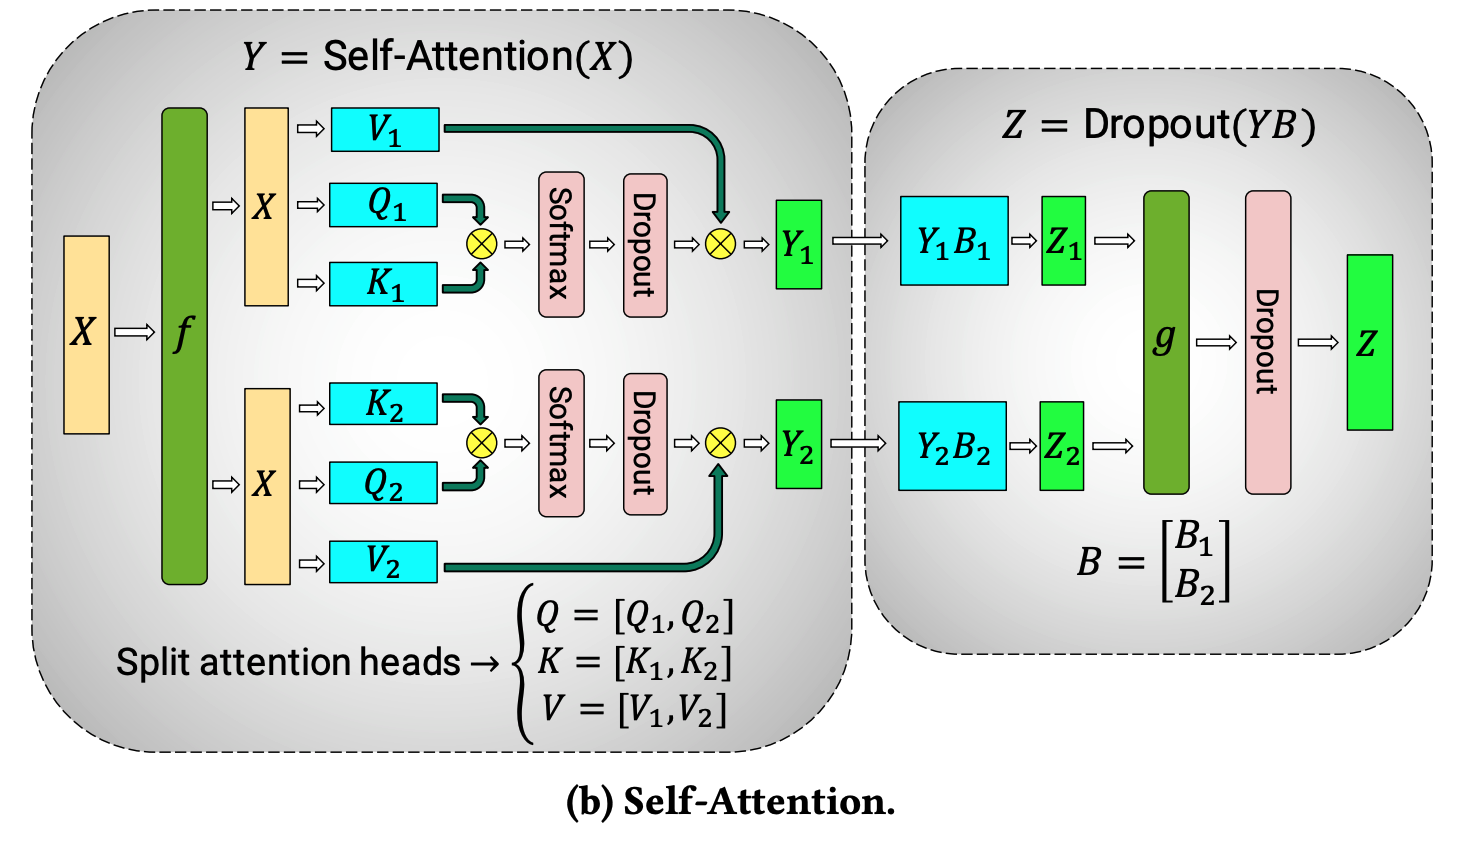

## Usage of Megatron-LM

See more details in [Megatron-LM](https://github.com/NVIDIA/Megatron-LM)